In [1]:
import jax 
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap
import jax.scipy as jsp 

import numpy as onp 

import drpangloss
# from drpangloss.oifits_implaneia import load_oifits, cp_indices
from drpangloss.models import BinaryModelAngular, BinaryModelCartesian, OIData
from drpangloss.grid_fit import azimuthalAverage

import zodiax as zx
import equinox as eqx
import optimistix as optx 

import pyoifits as oifits

from functools import partial
import matplotlib.pyplot as plt
import matplotlib

/Users/benpope/opt/anaconda3/envs/pangloss/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fname = "NuHor_F480M.oifits"
ddir = "../data/"

data = oifits.open(ddir+fname)

data.verify('silentfix')


oidata = OIData(data)

In [3]:
true_values = [150., 150., 5e-4] # ra, dec, planet flux
binary = BinaryModelCartesian(true_values[0], true_values[1], true_values[2])

cvis_sim = binary.model(oidata.u, oidata.v, oidata.wavel) 

# fill out a new oidata model with simulated values
sim_data = {'u': oidata.u,
            'v': oidata.v,
            'wavel': oidata.wavel,
            'vis': oidata.to_vis(cvis_sim) + onp.random.randn(*oidata.vis.shape)*oidata.d_vis,
            'd_vis': oidata.d_vis,
            'phi': oidata.to_phases(cvis_sim) + onp.random.randn(*oidata.phi.shape)*oidata.d_phi,
            'd_phi': oidata.d_phi,
            'i_cps1': oidata.i_cps1,
            'i_cps2': oidata.i_cps2,
            'i_cps3': oidata.i_cps3,
            'v2_flag': oidata.v2_flag,
            'cp_flag': oidata.cp_flag}

oidata_sim = OIData(sim_data)

In [4]:
def loglike(values, params, data_obj, model_class):
    '''
    Abstract log-likelihood function for a given model class and data object, assuming Gaussian errors.

    Parameters
    ----------
    values : array-like
        Values of the model parameters.
    params : list
        List of parameter names.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.

    Returns
    -------
    float
        Log-likelihood value.
    '''

    param_dict = dict(zip(params, values))

    model_data = data_obj.model(model_class(**param_dict))
    data, errors = data_obj.flatten_data()

    return -0.5*np.sum((data - model_data)**2/errors**2)

def loglike_nosignal(values, params, data_obj, model_class):
    '''
    Abstract null log-likelihood function for a given model class and data object, assuming Gaussian errors.

    Parameters
    ----------
    values : array-like
        Values of the model parameters.
    params : list
        List of parameter names.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.

    Returns
    -------
    float
        Log-likelihood value.
    '''

    param_dict = dict(zip(params, values))

    model_data = data_obj.model(model_class(**param_dict))
    _, errors = data_obj.flatten_data()
    data = np.concatenate([np.ones_like(data_obj.vis), np.zeros_like(data_obj.phi)])

    return -0.5*np.sum((data - model_data)**2/errors**2)


@partial(jit, static_argnames=("model_class"))
def likelihood_grid(data_obj, model_class, samples_dict):
    ''' 
    Function to vmap a likelihood function over a grid of parameter values provided in a dictionary.

    Parameters
    ----------
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.
    samples_dict: dict
        Dictionary of parameter names and values to be fitted to the data.

    Returns
    -------
    array-like
        Log-likelihood values over the grid of parameter values.
    '''
    
    params = list(samples_dict.keys())
    samples = samples_dict.values()
    vals = np.array(np.meshgrid(*samples))
    vals_vec = vals.reshape((len(vals), -1)).T
    
    fn = vmap(lambda values: loglike(values, params, data_obj,model_class))

    return fn(vals_vec).reshape(vals.shape[1:]) # check the shapes output here

In [5]:
params = ["dra", "ddec", "flux"]

loglike(true_values, params, oidata_sim,BinaryModelCartesian,) # once to jit

Array(-20.2562846, dtype=float64)

In [6]:
grad(loglike,argnums=0)(np.array(true_values)+np.array([0,1,2]), params, oidata_sim,BinaryModelCartesian) # once to jit

Array([ 4.75697684e+06,  3.29162192e+05, -3.44181530e+08], dtype=float64)

In [7]:
%%timeit 
loglike(true_values, params, oidata_sim,BinaryModelCartesian)

1.43 ms ± 86.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
samples_dict = {
    "dra":  np.linspace(600., -600., 100), # left is more RA 
    "ddec": np.linspace(-600., 600., 100), # up is more dec
    "flux": 10**np.linspace(-6, -1, 100)}

loglike_im = likelihood_grid(oidata_sim, BinaryModelCartesian, samples_dict) # calculate once to jit

In [9]:
%%timeit
loglike_im = likelihood_grid(oidata_sim, BinaryModelCartesian, samples_dict)

719 ms ± 74.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Function to plot this automatically.

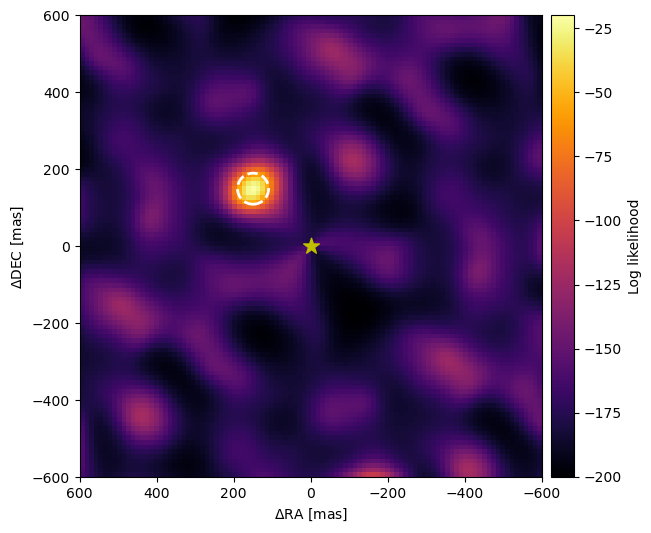

In [10]:
def plot_likelihood_grid(loglike_im, samples_dict,truths=None):
    '''
    Plot the results of a likelihood_grid calculation.

    Parameters
    ----------
    loglike_im : array
        The likelihood grid, output of likelihood_grid
    samples_dict : dict
        Dictionary of samples used in the grid calculation
    truths : list, optional 
        List of true values for the parameters, default None
    '''

    plt.figure(figsize=(12,6))

    plt.imshow(loglike_im.max(axis=2).T, cmap="inferno",aspect="equal",
            extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                            samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
    plt.colorbar(shrink=1,label='Log likelihood', pad=0.01)
    plt.scatter(0,0,s=140,c='y',marker='*')

    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')

    if truths is not None:
        dra_inp, ddec_inp = truths[0], truths[1]
        plt.scatter(dra_inp,ddec_inp, 
                s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
    plt.gca().invert_yaxis() # up is more Dec

plot_likelihood_grid(loglike_im, samples_dict, truths=true_values)

Next, let's fit the best likelihood in each pixel by optimization.

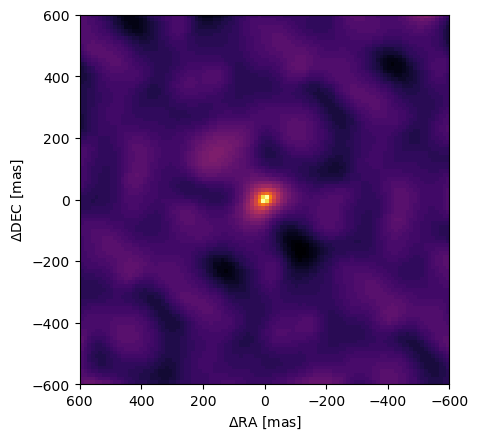

In [11]:
best_contrast_indices = np.argmax(loglike_im,axis=2)
best_contrasts = samples_dict['flux'][best_contrast_indices]
plt.imshow(best_contrasts.T, cmap="inferno",aspect="equal", norm=matplotlib.colors.LogNorm(),
           extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')

plt.gca().invert_yaxis() # up is more Dec

In [12]:
@partial(jit, static_argnames=("model_class"))
def optimized_contrast_grid(best_contrast_indices, data_obj, model_class, samples_dict):
    '''
    Function to optimize the contrast of a model over a grid of parameter values provided in a dictionary.

    Parameters
    ----------
    best_contrast_indices : array-like
        Indices of the best contrast values in a grid calculated with likelihood_grid.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.
    samples_dict: dict
        Dictionary of parameter names and values to be fitted to the data.

    Returns
    -------
    array-like
        Optimized contrast values over the grid of parameter values.

    '''
    
    params = list(samples_dict.keys())
    coords = [samples_dict[key] for key in ["dra", "ddec"]]
    ras, decs = np.meshgrid(*coords)
    vals = np.array([samples_dict['flux'][best_contrast_indices], ras, decs])
    vals_vec = vals.reshape((len(vals), -1)).T

    to_optimize = lambda flux, dra_inp, ddec_inp: -loglike([dra_inp, ddec_inp, flux], params, data_obj, model_class)
    bestcon = lambda flux, dra, ddec: optx.compat.minimize(to_optimize, x0= np.array([flux]), args=(np.array(dra),np.array(ddec)), 
                            method='BFGS', options={"maxiter":100}).x

    fn = vmap(lambda values: bestcon(*values))

    return fn(vals_vec).reshape(vals.shape[1:]) # check the shapes output here

optimized = optimized_contrast_grid(best_contrast_indices, oidata_sim, BinaryModelCartesian, samples_dict)

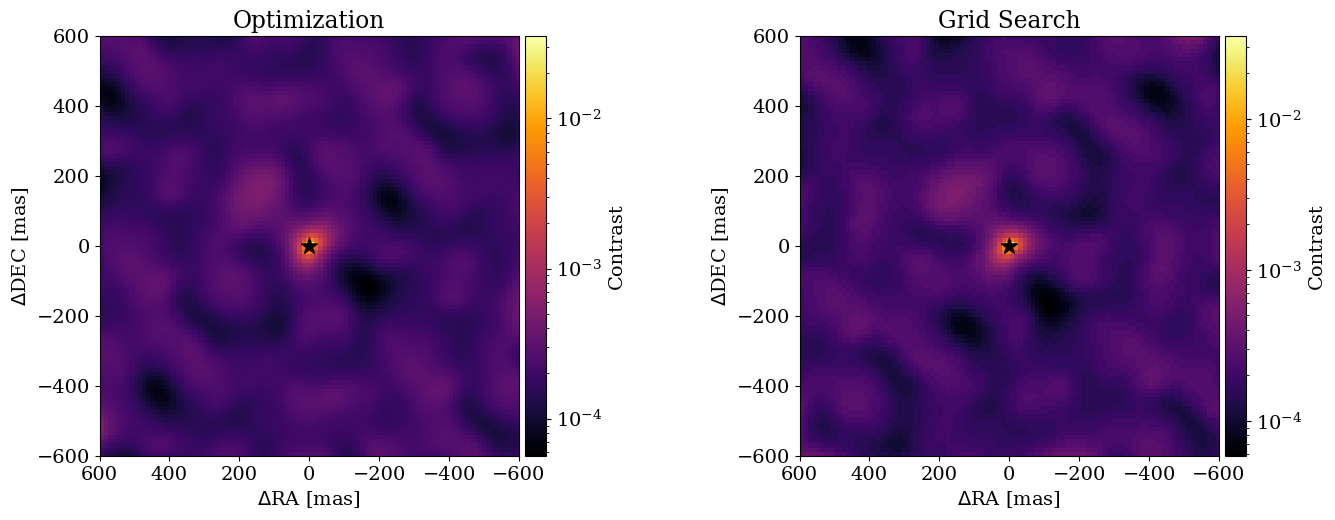

In [13]:
def plot_optimized_and_grid(loglike_im, optimized, samples_dict):

    best_contrast_indices = np.argmax(loglike_im,axis=2)
    best_contrasts = samples_dict['flux'][best_contrast_indices]

    plt.figure(figsize=(14,5))
    matplotlib.rcParams['figure.dpi'] = 100
    matplotlib.rcParams['font.family'] = ['serif']
    plt.rcParams.update({'font.size': 14})
    plt.subplot(1,2,1)
    plt.imshow(optimized,cmap='inferno', norm = matplotlib.colors.LogNorm(),
                        extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
    plt.colorbar(shrink=1,label='Contrast', pad=0.01)
    plt.scatter(0,0,s=140,c='black',marker='*')
    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')
    plt.title('Optimization')
    plt.gca().invert_yaxis()

    plt.subplot(1,2,2)
    plt.imshow(best_contrasts.T,cmap='inferno', norm = matplotlib.colors.LogNorm(),
                            extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                            samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
    plt.colorbar(shrink=1,label='Contrast', pad=0.01)
    plt.scatter(0,0,s=140,c='black',marker='*')
    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')
    plt.title('Grid Search')
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0.)
    plt.show()

plot_optimized_and_grid(loglike_im, optimized, samples_dict)

## Now let's calculate uncertainties by the Laplace method.

In [14]:
def laplace_cov(values, params, data_obj, model_class):

    '''
    Calculate the uncertainty with the Laplace method from an optimized fit between a model and data object.

    Parameters
    ----------
    Parameters
    ----------
    values : array-like
        Values of the model parameters.
    params : list
        List of parameter names.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.

    Returns
    -------
    array-like
        Covariance matrix.
    '''

    hess = jax.hessian(loglike, argnums=0)(values, params, data_obj, model_class)
    return -np.linalg.inv(np.array(hess))

laplace_cov(true_values, params, oidata_sim, BinaryModelCartesian)

def laplace_contrast_uncertainty(flux, dra, ddec, data_obj, model_class):

    '''
    Calculate the uncertainty with the Laplace method from an optimized fit between a model and data object.

    Parameters
    ----------
    Parameters
    ----------
    values : array-like
        Values of the model parameters.
    params : list
        List of parameter names.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.

    Returns
    -------
    array-like
        Uncertainty in the contrast.
    '''

    objective = lambda flux: -loglike([dra, ddec, flux], params, data_obj, model_class)
    hess = jax.hessian(objective)(flux)
    cov = 1/(np.array(hess))
    return np.sqrt(cov)

laplace_contrast_uncertainty(5e-4, 150., 150., oidata_sim, BinaryModelCartesian)

Array(2.72648636e-05, dtype=float64, weak_type=True)

In [15]:
@partial(jit, static_argnames=("model_class"))
def laplace_contrast_uncertainty_grid(best_contrast_indices, data_obj, model_class, samples_dict):
    '''
    Calculate the uncertainty with the Laplace method over a grid of parameters, for an optimized fit between a model and data object.

    Parameters
    ----------
    best_contrast_indices : array-like
        Indices of the best contrast values in a grid calculated with likelihood_grid.
    data_obj : OIData
        Object containing the data to be fitted.
    model_class : class
        Model class to be fitted to the data.
    samples_dict: dict
        Dictionary of parameter names and values to be fitted to the data.

    Returns
    -------
    array-like
        Uncertainty in the contrast.
    '''

    params = list(samples_dict.keys())
    coords = [samples_dict[key] for key in ["dra", "ddec"]]
    ras, decs = np.meshgrid(*coords)
    vals = np.array([samples_dict['flux'][best_contrast_indices], ras, decs])
    vals_vec = vals.reshape((len(vals), -1)).T

    
    sigma = lambda flux, dra, ddec: laplace_contrast_uncertainty(flux, dra, ddec, data_obj, model_class)
    fn = vmap(lambda values: sigma(*values))

    return fn(vals_vec).reshape(vals.shape[1:]) # check the shapes output here

laplace_sigma_grid = laplace_contrast_uncertainty_grid(best_contrast_indices, oidata_sim, BinaryModelCartesian, samples_dict)


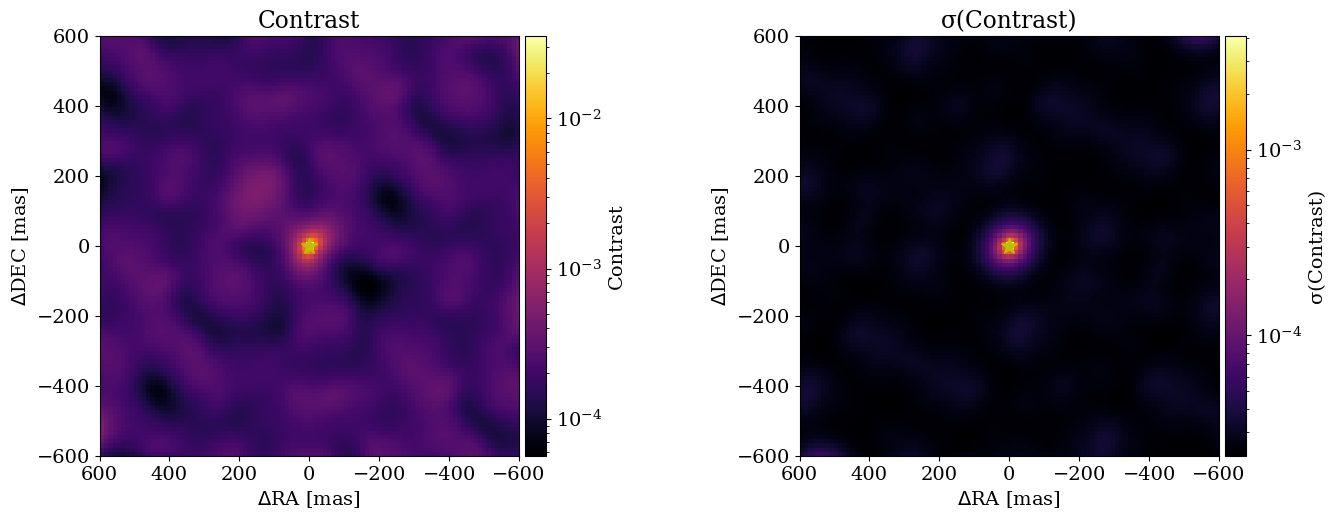

In [16]:
def plot_optimized_and_sigma(contrast, sigma_grid, samples_dict,snr=False):

    '''
    Plot the results of an optimized contrast grid calculation and the corresponding uncertainty grid.

    Parameters
    ----------
    contrast : array
        The optimized contrast grid, output of optimized_contrast_grid  
    sigma_grid : array
        The uncertainty grid, output of laplace_contrast_uncertainty_grid
    samples_dict : dict
        Dictionary of samples used in the grid calculation
    snr : bool, optional
        If True, plot the SNR instead of the uncertainty, default False
    
    '''

    plt.figure(figsize=(14,5))
    matplotlib.rcParams['figure.dpi'] = 100
    matplotlib.rcParams['font.family'] = ['serif']
    plt.rcParams.update({'font.size': 14})
    plt.subplot(1,2,1)
    plt.imshow(contrast,cmap='inferno', norm = matplotlib.colors.LogNorm(),
                        extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
    plt.colorbar(shrink=1,label='Contrast', pad=0.01)
    plt.scatter(0,0,s=140,c='y',marker='*')
    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')
    plt.title('Contrast')
    plt.gca().invert_yaxis()

    plt.subplot(1,2,2)
    if snr:
        plt.imshow(contrast/sigma_grid,cmap='inferno',norm=matplotlib.colors.PowerNorm(1),
                                extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                                samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
        plt.colorbar(shrink=1,label='SNR', pad=0.01)
        plt.scatter(0,0,s=140,c='y',marker='*') # mark star at origin
        plt.title('SNR')

    else:
        plt.imshow(sigma_grid,cmap='inferno', norm = matplotlib.colors.LogNorm(),
                                extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                                samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
        plt.colorbar(shrink=1,label='σ(Contrast)', pad=0.01)
        plt.scatter(0,0,s=140,c='y',marker='*') # mark star at origin
        plt.title('σ(Contrast)')

    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0.)
    plt.show()

plot_optimized_and_sigma(optimized, laplace_sigma_grid, samples_dict,snr=False)

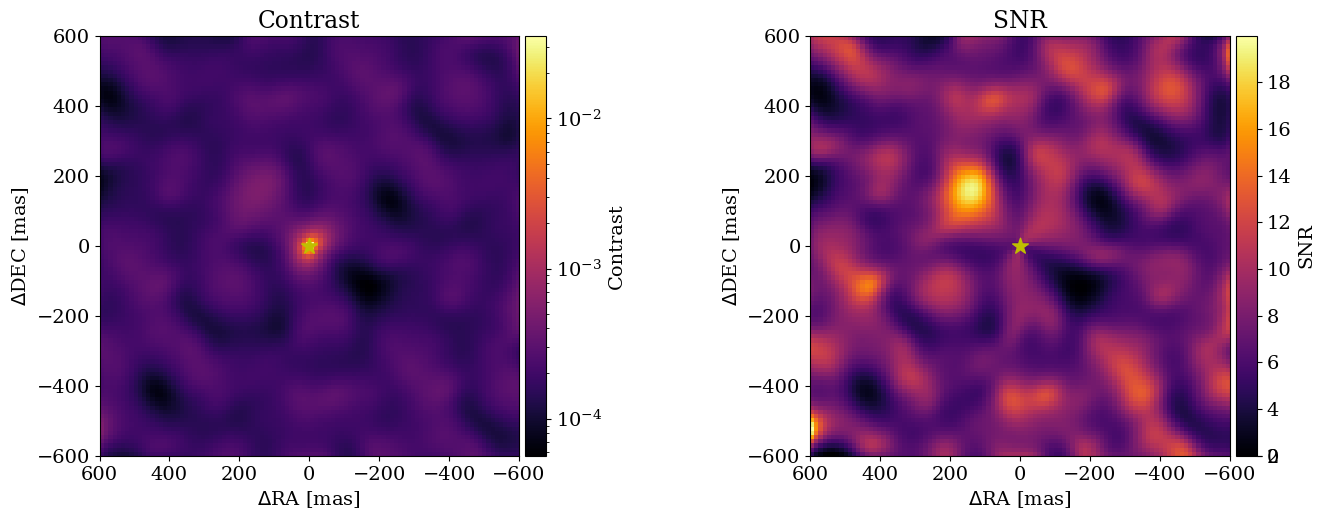

In [17]:
best_contrast_indices = np.argmax(loglike_im,axis=2)
best_contrasts = samples_dict['flux'][best_contrast_indices]
plot_optimized_and_sigma(optimized, laplace_sigma_grid, samples_dict,snr=True)

In [18]:
@partial(vmap, in_axes=(0,0,None))
@partial(vmap, in_axes=(None,None,0))
def calc_upperlimit(mean,sigma,percentile):

    #eqn 8 from Ruffio+2018
    limit = jsp.stats.norm.ppf((percentile+(1-percentile)*jsp.stats.norm.cdf(0,loc=mean,scale=sigma)),loc=mean,scale=sigma)

    return limit

perc = np.array([jsp.stats.norm.cdf(2.)])
limits = calc_upperlimit(optimized.flatten(),laplace_sigma_grid.flatten(),perc)
limits_rs = limits.reshape(*optimized.shape,perc.shape[0])[:,:,0]

rad_width_ruffio, avg_width_ruffio  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:]), returnradii=True, binsize=2, stddev=False)
_, std_width_ruffio  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:]), returnradii=True, binsize=2, stddev=True)

Text(0.5, 1.05, 'Ruffio Method')

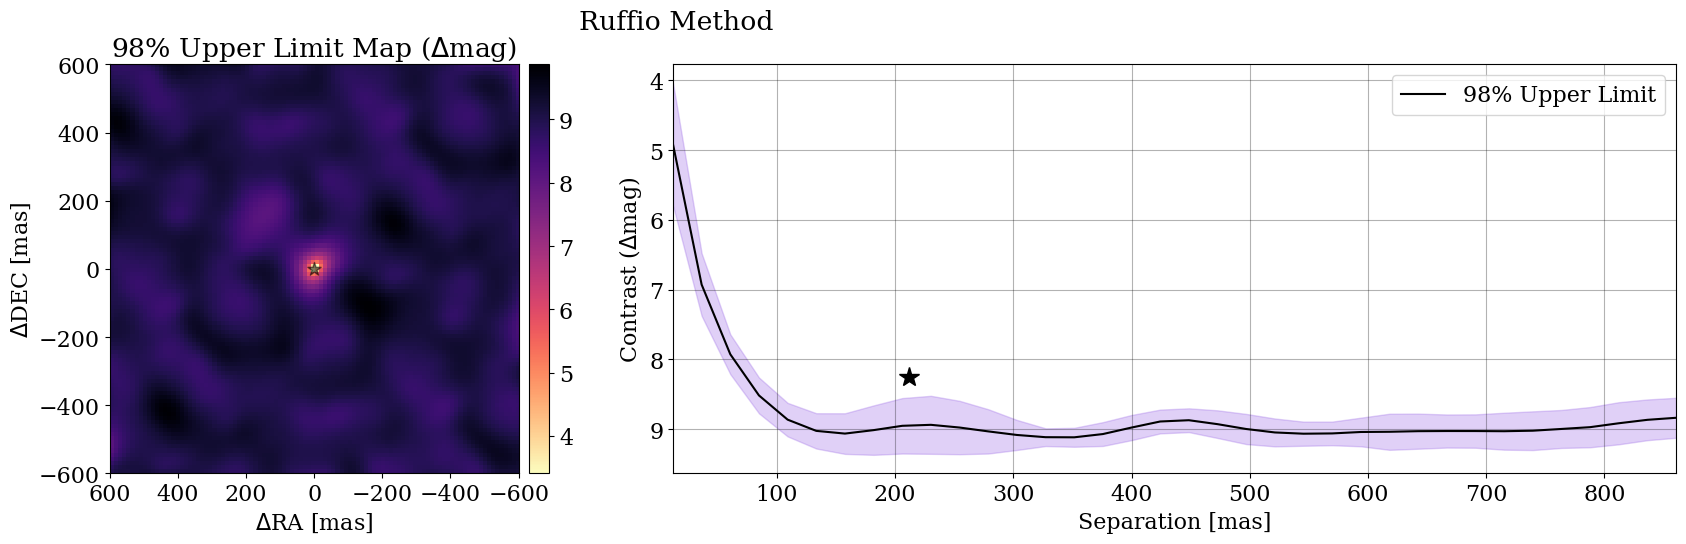

In [20]:
def plot_contrast_limits(contrast_limits, samples_dict, rad_width, avg_width, std_width, true_values=None):  
    ''' 
    Plot the contrast limits calculated with the Ruffio or Absil methods.

    TODO: pass in the percentile or number of sigmas as a parameter to be used in legends.

    Parameters
    ----------
    contrast_limits : array
        The contrast limits calculated with the Ruffio or Absil methods.
    samples_dict : dict
        Dictionary of samples used in the grid calculation
    rad_width : array
        Radial width of the contrast limits.
    avg_width : array
        Average width of the contrast limits.
    std_width : array
        Standard deviation of the contrast limits.
    true_values : list, optional
        List of true values for the parameters, default None         
    
    '''

    plt.figure(figsize=(20,5))
    matplotlib.rcParams['figure.dpi'] = 150
    matplotlib.rcParams['font.family'] = ['serif']
    plt.rcParams.update({'font.size': 16})


    # first show x% upper limit map

    plt.subplot(1,2,1)
    plt.imshow(-2.5*np.log10(contrast_limits[:,:]),cmap=matplotlib.colormaps['magma_r'],
                                extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                                samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
    plt.colorbar(shrink=1, pad=0.01)
    plt.scatter(0,0,marker='*',s=100,c='black',alpha=0.5)
    plt.gca().invert_yaxis()
    plt.title('98% Upper Limit Map ($\\Delta$mag)')
    plt.xlabel('$\\Delta$RA [mas]')
    plt.ylabel('$\\Delta$DEC [mas]')


    # then show contrast curve including detected target
    plt.subplot(1,2,2)
    dx = np.abs(np.median(np.diff(samples_dict["dra"])))
    plt.plot(rad_width*dx,avg_width,'-k',label="98% Upper Limit")
    plt.fill_between(rad_width*dx,avg_width - std_width,avg_width + std_width,color=(0.6,0.4,0.9),alpha=0.3)
    plt.ylabel('Contrast ($\\Delta$mag)')
    plt.xlabel('Separation [mas]')
    plt.gca().invert_yaxis()
    plt.xlim(np.nanmin(rad_width*dx+avg_width*0.),np.nanmax(rad_width*dx+avg_width*0.))
    plt.grid(color='black',alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout(pad=0.)

    if true_values is not None:
        true_dra, true_ddec, true_contrast = true_values
        plt.plot(np.sqrt(true_dra**2+true_ddec**2),-2.5*np.log10(true_contrast),marker='*',c='k',markersize=15) # detected value

plot_contrast_limits(limits_rs, samples_dict, rad_width_ruffio, avg_width_ruffio, std_width_ruffio,true_values=true_values)
plt.suptitle('Ruffio Method',y=1.05)

In [21]:
from numpyro.distributions.util import gammaincinv
from scipy.stats import chi2

def chi2ppf(p,df): 
    '''
    tensorflow-probability backend for the percentile function for chi2
    tested - matches scipy.stats.chi2.ppf to machine precision over domain we care about

    Parameters
    ----------
    p : array-like
        Percentile value
    df : array-like
        Degrees of freedom

    Returns
    -------
    array-like
        Corresponding chi2 value to the percentile
    '''
    return gammaincinv(df/2.,p)*2


def nsigma(chi2r_test,
           chi2r_true,
           ndof):
    """
    Parameters
    ----------
    chi2r_test: float
        Reduced chi-squared of test model.
    chi2r_true: float
        Reduced chi-squared of true model.
    ndof: int
        Number of degrees of freedom.
    
    Returns
    -------
    nsigma: float
        Detection significance.
    """
    
    q = jax.scipy.stats.chi2.cdf(ndof*chi2r_test/chi2r_true, ndof)
    p = 1.-q
    nsigma = np.sqrt(chi2ppf(p, 1.))
    
    return nsigma


@partial(jit, static_argnames=("model_class"))
def absil_limits(samples_dict, data_obj, model_class, sigma):
    '''
    
    Using Jax for optimization, calculate the detection limits for a given model class and data object.
    This is by finding the contrast at which the detection significance is equal to the sigma value.
    For example, if we set sigma = 3, we optimize in each coordinate cell to find the contrast 
    at which we would be 3 sigma confident that the companion is detected.

    Parameters
    ----------
    samples_dict: dict
        Dictionary of parameter names and values to be fitted to the data, eg dra and ddec grids.
    data_obj: object
        Observational data in the format of an OIData object.
    model_class: class
        Model class to be fitted to the data.
    sigma: float
        Detection significance.

        
    Returns
    -------
    res: float
        Maximum relative flux of companion.
    '''

    ndof = data_obj.vis.size + data_obj.phi.size # number of degrees of freedom

    # unpack the samples dict
    params = list(samples_dict.keys())
    coords = [samples_dict[key] for key in ["dra", "ddec"]] # TODO: make these arbitrary coordinate labels, eg sep and position angle
    ras, decs = np.meshgrid(*coords)
    vals = np.array([ras, decs])
    vals_vec = vals.reshape((len(vals), -1)).T

    # define intermediate function: nsigma detection significance

    # define chi2 wrappers
    chi2_bin = lambda flux, dra_inp, ddec_inp: -2*loglike([dra_inp, ddec_inp, flux], params, data_obj, model_class)/ndof
    chi2_null = chi2_bin(0., 0., 0.)

    # define optimization wrapper
    to_optimize = lambda flux, dra_inp, ddec_inp: (nsigma(chi2_bin(10.**(flux), dra_inp, ddec_inp)/ndof, chi2_null/ndof, ndof) - sigma)**2

    #optimize
    bestcon = lambda dra, ddec: optx.compat.minimize(to_optimize, x0 = np.array([-4.]), args=(np.array(dra),np.array(ddec)), 
                            method='BFGS', options={"maxiter":100}).x

    fn = vmap(lambda values: bestcon(*values))

    limits = 10**fn(vals_vec).reshape(vals.shape[1:]) # check the shapes output here
    limits_clipped = np.clip(limits, 1e-6, 1) # clip to 1e-6

    return limits_clipped

In [22]:
limits_absil = absil_limits(samples_dict, oidata_sim, BinaryModelCartesian, 5.)

rad_width_absil, avg_width_absil  = azimuthalAverage(-2.5*np.log10(limits_absil[:,:]), returnradii=True, binsize=2, stddev=False)
_, std_width_absil  = azimuthalAverage(-2.5*np.log10(limits_absil[:,:]), returnradii=True, binsize=2, stddev=True)

Text(0.5, 1.05, 'Absil Method')

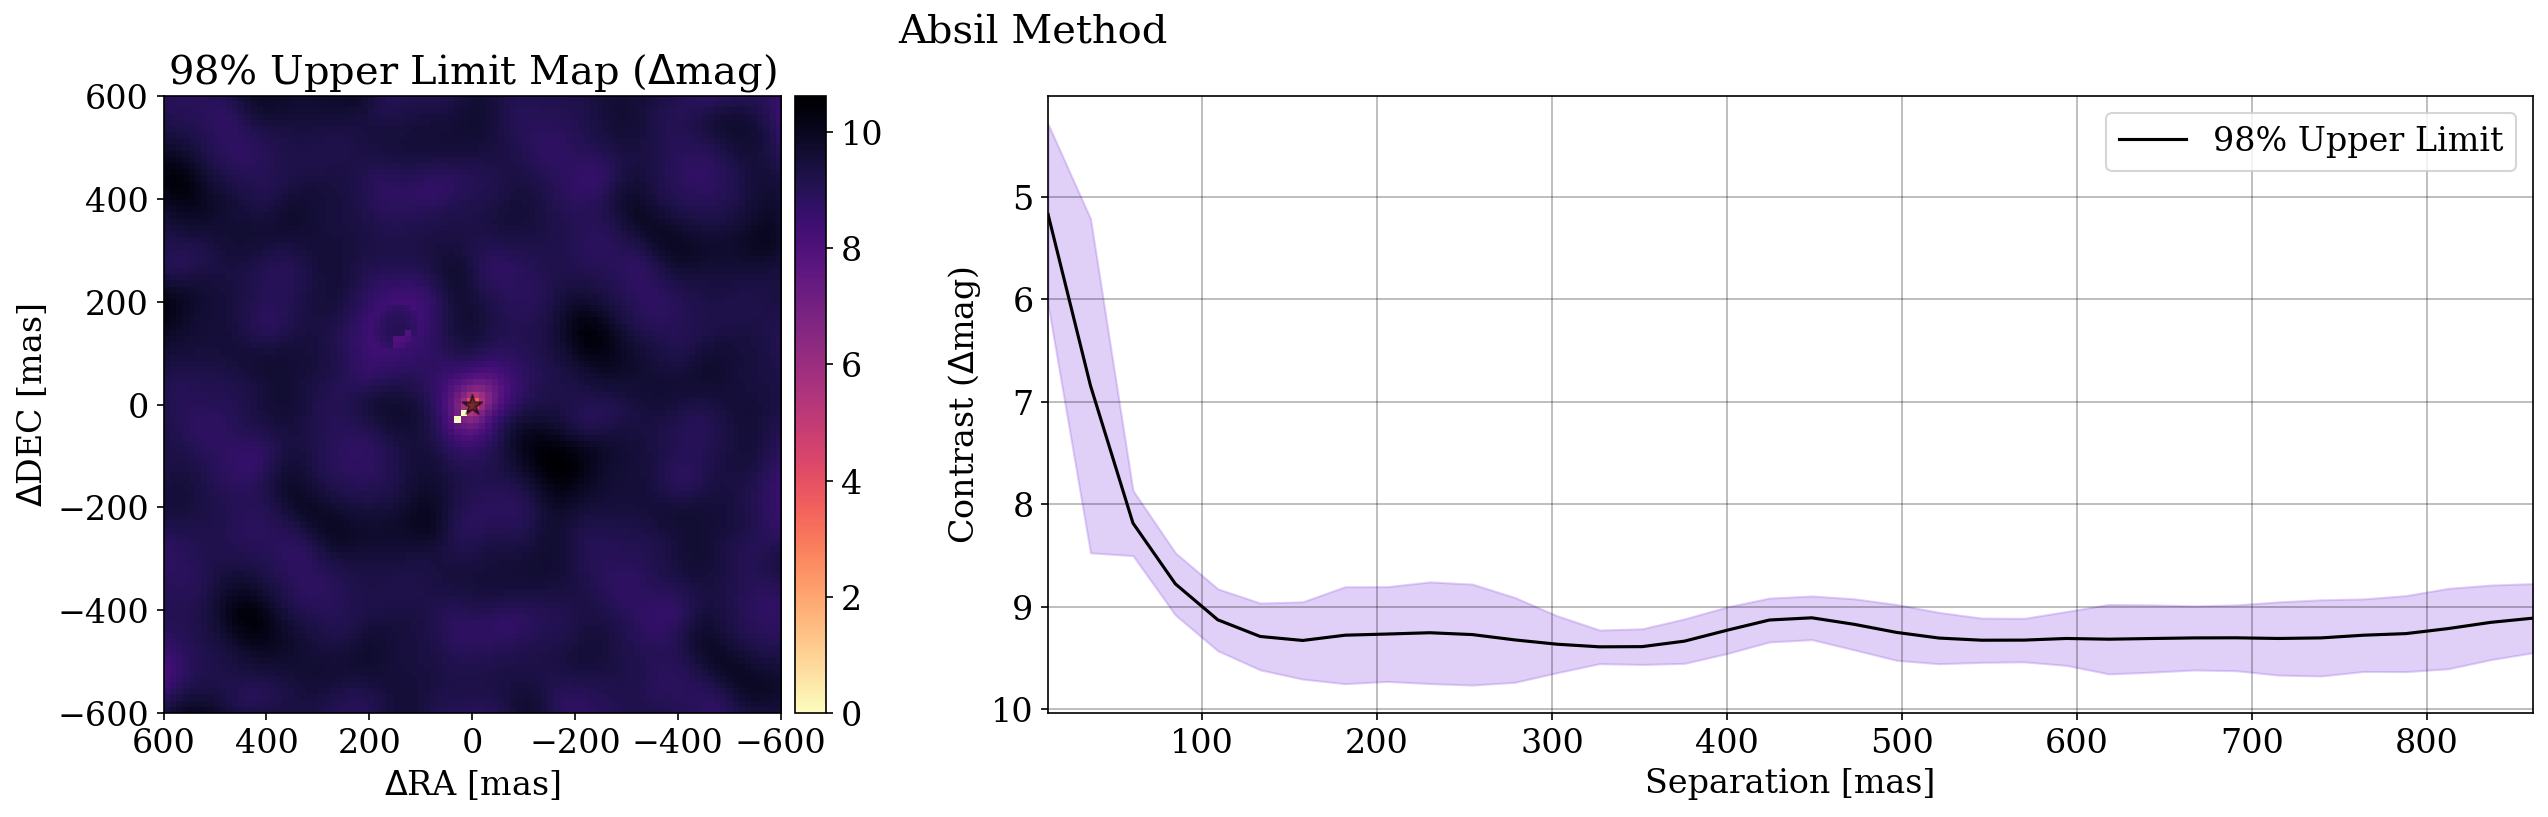

In [23]:
plot_contrast_limits(limits_absil, samples_dict, rad_width_absil, avg_width_absil, std_width_absil)
plt.suptitle('Absil Method',y=1.05)